# Bounding Box Regression Model for Fetal Anatomic Structures

## Setup

### Libraries

In [60]:
import os
import gc
from collections import defaultdict
from typing import Optional, Iterator
import hashlib
import json

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard.writer import SummaryWriter

import torchvision.models as models
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights

import albumentations as A

import numpy as np
from numpy.typing import NDArray

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm.auto import tqdm

import mlflow
from mlflow.data.dataset import Dataset as MLFLowDataset

from dotenv import load_dotenv


### Configuration

In [61]:
load_dotenv()

True

In [62]:
np.random.seed = 0

In [63]:
# Model Configuraton
TARGET_HEIGHT = 400
TARGET_WIDTH = 600
# Dataset Configuration
DATASET_DIR = os.getenv("DATASET_DIR")
DATASET_IMAGES_DIR_NAME = "Images"
DATASET_IMAGES_DIR = os.path.join(*[DATASET_DIR, DATASET_IMAGES_DIR_NAME])
ANNOTATIONS_PATH = os.path.join(*[DATASET_DIR, "ObjectDetection.xlsx"])
VERSIONING_FILE_NAME = "Versioning.xlsx"
VERSIONING_PATH = os.path.join(*[DATASET_DIR, VERSIONING_FILE_NAME])
DATASET_VERSION = "V1"
DATASET_TRAIN_VAL_COL = "Train + Val Filenames"
DATASET_TEST_COL = "Test Filenames"
# Experiment logging
MLFLOW_URI = os.getenv("MLFLOW_URI")
MLFLOW_EXPERIMENT_NAME = f"Fetal_Structures_BB_Regression_{TARGET_HEIGHT}x{TARGET_WIDTH}"
MLFLOW_USER = os.getenv("MLFLOW_USER")
MODEL_NAME = f"fetal_structures_bb_regressor_{TARGET_HEIGHT}x{TARGET_WIDTH}"
TB_LOG_DIR = r"./tb_logs"
# Training parameters
TRAIN_SPLIT, VAL_SPLIT = 0.8, 0.2
K_FOLDS = 5
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 10
# Temp dirs
CHECKPOINTS_DIR = r"./checkpoints"
if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

### Experiment Setup

In [64]:
# Logging with tensorboard and mlflow
if not os.path.exists(TB_LOG_DIR):
    os.makedirs(TB_LOG_DIR, exist_ok=True)
TB_WRITER = SummaryWriter(log_dir=TB_LOG_DIR)
if MLFLOW_URI is None:
    raise RuntimeError("MLFLOW_URI environment variable is not set.")
mlflow.set_tracking_uri(MLFLOW_URI)
MLFLOW_EXPERIMENT = mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

In [65]:
# Setup device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# check if windows is being used and try to import torch-directml
if os.name == 'nt':
    try:
        import torch_directml
        DEVICE = torch_directml.device()
    except ImportError:
        # type: ignore
        try:
            ! pip install torch-directml==0.2.4.dev240913
            import torch_directml
            DEVICE = torch_directml.device()
        except Exception as e: # pylint: disable=broad-except
            raise e
    except Exception as e: # pylint: disable=broad-except
        print(f"Error occurred while setting up DirectML: {e}")
print(f"Using device: {DEVICE}")

Using device: cuda


## Dataset Loading and Preprocessing

In [66]:
df = pd.read_excel(ANNOTATIONS_PATH)
ANNOTATIONS: dict[str, list[tuple[int, tuple[int, int, int, int]]]] = defaultdict(list)

STRUCTURES_TO_EXTRACT: list[str] = ["NT", "nasal bone", "nasal skin"]
STRUCTURES_TO_TRAIN_ON: list[str] = ["NT", "NB"]
STRUCTURES_UNION: list[str] = ["NT", "NB", "nasal bone", "nasal skin"]
STRUCTURE_TO_ID: dict[str, int] = {name: i for i, name in enumerate(STRUCTURES_UNION)}
ID_TO_STRUCTURE: dict[int, str] = {v: k for k, v in STRUCTURE_TO_ID.items()}
NUMBER_OF_CLASSES = len(STRUCTURES_TO_TRAIN_ON)

COLORS = plt.get_cmap('tab10', NUMBER_OF_CLASSES)
COLORS_MAP = {structure: COLORS(i) for i, structure in enumerate(STRUCTURES_TO_TRAIN_ON)}

# First, load preexisting annotations
for _, row in df.iterrows():
    fname, structure = row['fname'], row['structure']
    if row['structure'] not in STRUCTURES_TO_EXTRACT:
        continue

    class_id = STRUCTURE_TO_ID[structure]

    hmin, wmin, hmax, wmax = row['h_min'], row['w_min'], row['h_max'], row['w_max']
    box = (wmin, hmin, wmax, hmax)  # (xmin, ymin, xmax, ymax)
    ANNOTATIONS[fname].append((class_id, box))

# Then, combine nasal bone and nasal skin into by finding the smallest box that fits both
for fname, annotations in ANNOTATIONS.items():
    nasal_bone_box = None
    nasal_skin_box = None

    # Find the nasal bone and nasal skin annotations for this image
    for class_id, box in annotations:
        if ID_TO_STRUCTURE[class_id] == 'nasal bone':
            nasal_bone_box = box
        elif ID_TO_STRUCTURE[class_id] == 'nasal skin':
            nasal_skin_box = box

    # If both structures are present, create the combined NB box
    if nasal_bone_box and nasal_skin_box:
        xmin_nb = min(nasal_bone_box[0], nasal_skin_box[0])
        ymin_nb = min(nasal_bone_box[1], nasal_skin_box[1])
        xmax_nb = max(nasal_bone_box[2], nasal_skin_box[2])
        ymax_nb = max(nasal_bone_box[3], nasal_skin_box[3])

        # Add the combined box as a new annotation
        NB_class_id = STRUCTURE_TO_ID['NB']
        ANNOTATIONS[fname].append((NB_class_id, (xmin_nb, ymin_nb, xmax_nb, ymax_nb)))

        # Remove the individual nasal bone and nasal skin annotations
        ANNOTATIONS[fname] = [
            (cid, box) for cid, box in annotations
            if ID_TO_STRUCTURE[cid] not in ['nasal bone', 'nasal skin']
        ]

# Save the old mappings before updating them
OLD_ID_TO_STRUCTURE = ID_TO_STRUCTURE.copy()

# Update the conversion dicts to only include structures we're training on
STRUCTURE_TO_ID = {name: i for i, name in enumerate(STRUCTURES_TO_TRAIN_ON)}
ID_TO_STRUCTURE = {v: k for k, v in STRUCTURE_TO_ID.items()}

# Update all annotations to use the new class IDs
for fname in list(ANNOTATIONS.keys()):
    updated_annotations = []
    for old_class_id, box in ANNOTATIONS[fname]:
        structure_name = OLD_ID_TO_STRUCTURE[old_class_id]
        if structure_name in STRUCTURES_TO_TRAIN_ON:
            new_class_id = STRUCTURE_TO_ID[structure_name]
            updated_annotations.append((new_class_id, box))
    ANNOTATIONS[fname] = updated_annotations

In [67]:
print(STRUCTURE_TO_ID)
print(ID_TO_STRUCTURE)

{'NT': 0, 'NB': 1}
{0: 'NT', 1: 'NB'}


In [68]:
df.head(10)

,fname,structure,h_min,w_min,h_max,w_max
0,pd_168.png,thalami,178,171,244,261
1,pd_168.png,nasal bone,96,308,111,349
2,pd_168.png,palate,133,300,205,408
3,pd_168.png,nasal skin,86,324,95,349
4,pd_168.png,nasal tip,79,345,89,376
5,pd_168.png,midbrain,247,173,328,231
6,pd_168.png,NT,385,257,418,464
7,pd_168.png,IT,301,213,328,290
8,pd_168.png,CM,345,216,367,304
9,pd_169.png,nasal tip,80,240,86,264


In [69]:
ANNOTATIONS["pd_168.png"]

[(0, (257, 385, 464, 418)), (1, (308, 86, 349, 111))]

In [70]:
TRAIN_TRANSFORMS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

In [71]:
class AnatomyDataset(Dataset):
    def __init__(
        self,
        img_dir: str,
        img_names: Optional[list[str]] = None,
    ):
        self.img_dir = img_dir
        self.img_names = sorted(os.listdir(img_dir)) if img_names is None else img_names
        self.n_imgs = len(self.img_names)
        self.data: dict[str, NDArray[np.float32]] = {}
        self.load_data()

    def __len__(self):
        return self.n_imgs
    
    def load_data(self):
        self.data = {}
        gc.collect()
        images = np.zeros((self.n_imgs, TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32)
        dataset_bounding_boxes = np.zeros((self.n_imgs, NUMBER_OF_CLASSES, 4), dtype=np.float32)
        dataset_class_masks = np.zeros((self.n_imgs, NUMBER_OF_CLASSES), dtype=np.float32)
        for index, fname in enumerate(self.img_names):
            img_path = os.path.join(self.img_dir, fname)
            image = np.array(Image.open(img_path).convert('L'), dtype=np.float32)
            original_height, original_width = image.shape
            bboxes_list = []
            class_labels_list = []
            for class_id, (xmin, ymin, xmax, ymax) in ANNOTATIONS[fname]:
                bboxes_list.append([xmin, ymin, xmax, ymax])
                class_labels_list.append(class_id)
            bounding_boxes = np.zeros((NUMBER_OF_CLASSES, 4), dtype=np.float32)
            class_masks = np.zeros(NUMBER_OF_CLASSES, dtype=np.float32)
            for class_id, (xmin, ymin, xmax, ymax) in zip(class_labels_list, bboxes_list):
                cx = ((xmin + xmax) / 2) / original_width
                cy = ((ymin + ymax) / 2) / original_height
                bw = (xmax - xmin) / original_width
                bh = (ymax - ymin) / original_height
                class_masks[int(class_id)] = 1
                bounding_boxes[int(class_id)] = np.array([cx, cy, bw, bh], dtype=np.float32)
            image = A.Compose([
                A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
                A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
            ])(image=image)['image'] # Does not affect yolo format bboxes
            images[index] = image
            dataset_bounding_boxes[index] = bounding_boxes
            dataset_class_masks[index] = class_masks
        self.data["images"] = images
        self.data["bboxes"] = dataset_bounding_boxes
        self.data["class_masks"] = dataset_class_masks
    
    def get_data(self, idx) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        return (
            self.data["images"][idx],
            self.data["class_masks"][idx],
            self.data["bboxes"][idx]
        )

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return (
            torch.tensor(self.data["images"][idx]).unsqueeze(0),
            torch.tensor(self.data["class_masks"][idx]),
            torch.tensor(self.data["bboxes"][idx])
        )


class AnatomyDatasetSubset(AnatomyDataset):
    def __init__(
            self,
            base_dataset: AnatomyDataset,
            indices: list[int] | NDArray[np.integer],
            transform: Optional[A.Compose] = None,
        ):
        self.base_dataset = base_dataset
        self.transform = A.Compose(
            [transform if transform is not None else A.NoOp()],
            bbox_params=A.BboxParams(
                format='yolo',
            )
        )
        self.indices = indices
        self.img_names = [self.base_dataset.img_names[i] for i in self.indices]
        self.n_imgs = len(self.indices)
        self.data: dict[str, NDArray[np.float32]] = {}
        self.transform_data()
    
    def transform_data(self):
        self.data = {}
        gc.collect()
        images = np.zeros((self.n_imgs, TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32)
        dataset_bounding_boxes = np.zeros((self.n_imgs, NUMBER_OF_CLASSES, 4), dtype=np.float32)
        dataset_class_masks = np.zeros((self.n_imgs, NUMBER_OF_CLASSES), dtype=np.float32)
        for new_index, original_index in enumerate(self.indices):
            image, class_masks, bboxes = self.base_dataset.get_data(original_index)
            valid_bboxes_indeces = np.where(class_masks == 1)[0]
            valid_bboxes = [bboxes[i] for i in valid_bboxes_indeces]
            transformed_data = self.transform(
                image=image,
                bboxes=valid_bboxes)
            transformed_image = transformed_data['image']
            transformed_valid_bboxes = transformed_data['bboxes']
            transformed_bboxes = np.zeros((NUMBER_OF_CLASSES, 4), dtype=np.float32)
            for i, bbox in zip(valid_bboxes_indeces, transformed_valid_bboxes):
                transformed_bboxes[i] = np.array(bbox, dtype=np.float32)
            images[new_index] = transformed_image
            dataset_bounding_boxes[new_index] = transformed_bboxes
            dataset_class_masks[new_index] = class_masks
        self.data["images"] = images
        self.data["bboxes"] = dataset_bounding_boxes
        self.data["class_masks"] = dataset_class_masks

    def __iter__(self) -> Iterator[tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
        for idx in range(len(self)):
            yield self[idx]
        self.transform_data()

In [72]:
class ImageListDataset(MLFLowDataset):
    def __init__(
            self,
            names: list[str],
            source: str = VERSIONING_FILE_NAME,
            version: str = DATASET_VERSION
        ):
        self._names = names
        self._source = source
        self._version = version

    def to_dict(self):
        return {
            "name": "image_list_dataset",
            "digest": hashlib.md5(",".join(self._names).encode()).hexdigest(),
            "source_type": "inline",
            "source": self._source,
            "schema": None,
            "profile": json.dumps({
                "version": self._version,
                "num_images": len(self._names),
                "filenames": self._names
            }),
        }

In [73]:
VERSIONING_DF = pd.read_excel(VERSIONING_PATH, sheet_name=DATASET_VERSION)
TRAIN_VAL_IMG_NAMES = VERSIONING_DF[DATASET_TRAIN_VAL_COL].dropna().tolist()
TEST_IMG_NAMES = VERSIONING_DF[DATASET_TEST_COL].dropna().tolist()

In [74]:
if DATASET_DIR is None:
    raise RuntimeError("DATASET_DIR environment variable is not set.")
TRAIN_VAL_DATASET = AnatomyDataset(
    img_dir=DATASET_IMAGES_DIR,
    img_names=TRAIN_VAL_IMG_NAMES
)

In [75]:
if DATASET_DIR is None:
    raise RuntimeError("DATASET_DIR environment variable is not set.")
TEST_DATASET = AnatomyDataset(
    img_dir=DATASET_IMAGES_DIR,
    img_names=TEST_IMG_NAMES
)

In [76]:
def visualize_sample(
        dataset: AnatomyDataset,
        idx: int):
    colors = plt.get_cmap('tab10', len(STRUCTURES_TO_TRAIN_ON))
    color_map = {structure: colors(i) for i, structure in enumerate(STRUCTURES_TO_TRAIN_ON)}
    img, class_mask, boxes = dataset[idx]
    img = img.squeeze(0).numpy()  # Convert to 2D array

    # revert normalization for visualization
    img = (img * 0.5 + 0.5) * 255.0
    class_mask = class_mask.numpy()
    boxes = boxes.numpy()
    img_name = dataset.img_names[idx]
    # Convert tensor to numpy for plotting
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10), num=img_name)
    ax.imshow(img, cmap='gray')
    # Plot boxes for present classes
    present_classes = np.where(class_mask == 1)[0]
    for class_idx in present_classes:
        structure_name = ID_TO_STRUCTURE[int(class_idx)]
        color = color_map[structure_name]
        cx, cy, w, h = boxes[class_idx]
        # Convert normalized coordinates back to pixel coordinates
        cx_px = cx * TARGET_WIDTH
        cy_px = cy * TARGET_HEIGHT
        w_px = w * TARGET_WIDTH
        h_px = h * TARGET_HEIGHT
        # Convert center coordinates to top-left coordinates
        x = cx_px - w_px/2
        y = cy_px - h_px/2
        # Create rectangle patch
        rect = patches.Rectangle((x, y), w_px, h_px, linewidth=2, 
                               edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Get structure name
        ax.text(x, y-5, structure_name, color=color_map[structure_name], fontsize=8)
    ax.set_title(f'Image: {img_name}')
    ax.axis('off')
    fig.show()

/tmp/ipykernel_16674/4208312612.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


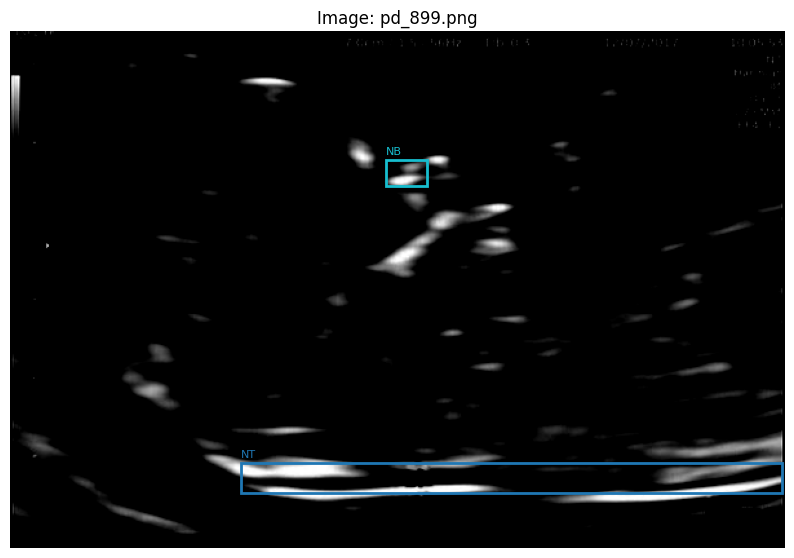

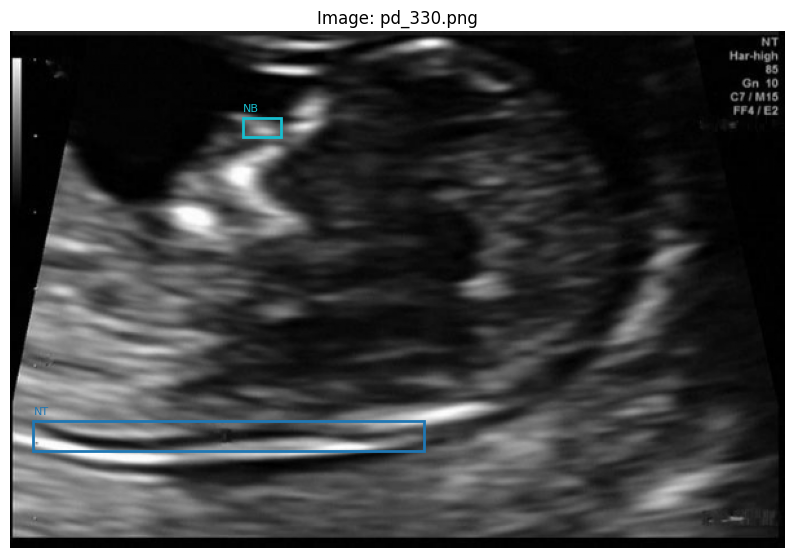

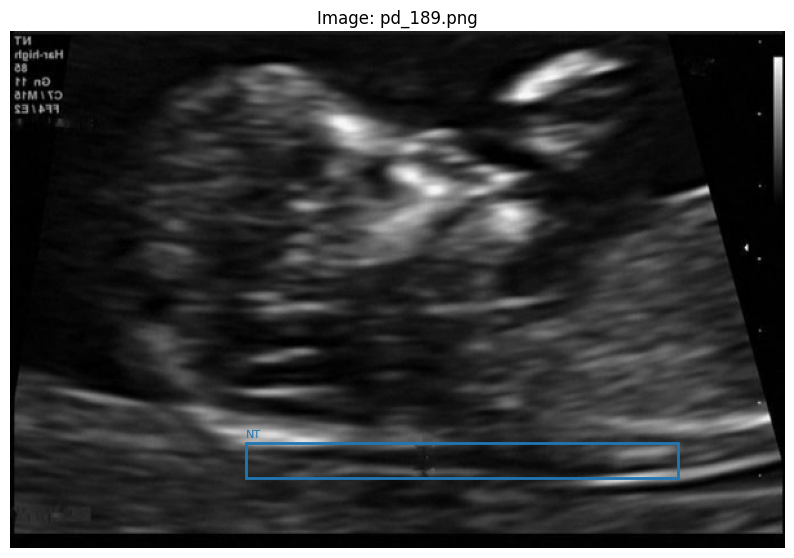

In [77]:
# sample 3 images from TRAIN_VAL_DATASET
indices = np.random.choice(len(TRAIN_VAL_DATASET), size=3, replace=False)
subset = AnatomyDatasetSubset(
    base_dataset=TRAIN_VAL_DATASET,
    indices=indices,
    transform=TRAIN_TRANSFORMS
)
for idx in range(len(subset)):
    visualize_sample(subset, idx)

## Model Definition

In [78]:
class DetectionHead(nn.Module):
    def __init__(self, in_features, num_classes=9):
        super().__init__()
        self.num_classes = num_classes
        # Classifier head: multi-label binary classification
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        # Regressor head: 4 coords per class (x, y, w, h)
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes * 4)
        )

    def forward(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        probs = self.classifier(features)                       # [B, 9]
        boxes: torch.Tensor = self.regressor(features)          # [B, 36]
        boxes = boxes.view(-1, self.num_classes, 4)             # [B, 9, 4]
        return probs, boxes

In [79]:
class FetusAnatomyBBRegressor(nn.Module):
    def __init__(self, num_classes=NUMBER_OF_CLASSES):
        super().__init__()
        # Load pretrained MobileNetV2 and adapt for 1 channel
        mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # Modify first conv layer to accept grayscale
        first_conv = self.features[0][0]
        new_conv = nn.Conv2d(1, first_conv.out_channels, kernel_size=first_conv.kernel_size,
                             stride=first_conv.stride, padding=first_conv.padding, bias=False)
        new_conv.weight.data = first_conv.weight.data.mean(dim=1, keepdim=True)
        self.features[0][0] = new_conv
        # Head
        self.head = DetectionHead(in_features=1280, num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.features(x)                    # [B, 1280, H', W']
        x = self.pool(x).view(x.size(0), -1)    # [B, 1280]
        return self.head(x)

In [80]:
def detection_loss(
        pred_probs: torch.Tensor,
        pred_boxes: torch.Tensor,
        gt_probs: torch.Tensor,
        gt_boxes: torch.Tensor,
        lambda_reg: float = 10.0
    ) -> torch.Tensor:
    """
    Combined loss for multi-label classification and bounding box regression.
    Args:
        pred_probs: [B, K] (sigmoid output)
        pred_boxes: [B, K, 4]
        gt_probs:   [B, K] (0 or 1)
        gt_boxes:   [B, K, 4]
    Returns:
        loss: scalar tensor
    """
    bce = nn.BCELoss()
    cls_loss = bce(pred_probs, gt_probs)
    # Compute Smooth L1 per box, then sum over coordinates
    smooth_l1 = nn.SmoothL1Loss(reduction='none')
    box_loss = smooth_l1(pred_boxes, gt_boxes).sum(dim=-1)  # [B, K]
    # Gate with class presence * predicted confidence
    gated_loss = gt_probs * pred_probs.detach() * box_loss  # [B, K]
    reg_loss = gated_loss.mean()
    return cls_loss + lambda_reg * reg_loss

## Training and Evaluation

### Metrics

In [81]:
def box_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    # box1, box2: (cx, cy, w, h) in normalized [0, 1]
    box1 = box1.clone()
    box2 = box2.clone()
    x1_min = float(box1[0] - box1[2]/2)
    y1_min = float(box1[1] - box1[3]/2)
    x1_max = float(box1[0] + box1[2]/2)
    y1_max = float(box1[1] + box1[3]/2)
    x2_min = float(box2[0] - box2[2]/2)
    y2_min = float(box2[1] - box2[3]/2)
    x2_max = float(box2[0] + box2[2]/2)
    y2_max = float(box2[1] + box2[3]/2)
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0.0

def compute_map_per_image(
    gt_mask: torch.Tensor,
    gt_boxes: torch.Tensor,
    pred_mask: torch.Tensor,
    pred_boxes: torch.Tensor,
    iou_thresh: float = 0.5
) -> float:
    aps = []
    for k in range(gt_mask.shape[0]):
        gt_present = gt_mask[k].item() == 1
        pred_present = pred_mask[k].item() > 0.5
        if gt_present and pred_present:
            iou = box_iou(gt_boxes[k], pred_boxes[k])
            aps.append(1.0 if iou >= iou_thresh else 0.0)
        elif not gt_present and not pred_present:
            continue  # true negative
        else:
            aps.append(0.0)  # either FN or FP
    return sum(aps) / len(aps) if aps else 0.0


### Training Functions

In [82]:
def train_epoch(
    model: FetusAnatomyBBRegressor,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer # type: ignore
) -> float:
    """
    Trains the model for one epoch.
    Args:
        model: The neural network model to train.
        dataloader: DataLoader providing training data batches.
        optimizer: Optimizer for updating model parameters.
    Returns:
        Average training loss for the epoch.
    """
    model.train()
    total_loss = 0
    batch_tqdm = tqdm(train_dataloader, desc="Training batches", leave=False, position=2)
    for batch in batch_tqdm:
        imgs: torch.Tensor = batch[0]
        cls_mask: torch.Tensor = batch[1]
        box_gt: torch.Tensor = batch[2]
        imgs = imgs.to(DEVICE)
        cls_mask = cls_mask.to(DEVICE)
        box_gt = box_gt.to(DEVICE)
        optimizer.zero_grad()
        cls_pred, box_pred = model(imgs)
        loss = detection_loss(cls_pred, box_pred, cls_mask, box_gt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    batch_tqdm.close()
    return total_loss / len(train_dataloader)

def validate(
    model: FetusAnatomyBBRegressor,
    val_loader: DataLoader,
    epoch: Optional[int] = None
) -> tuple[float, float]:
    """
    Evaluates the model on the validation set.
    Args:
        model: The neural network model to evaluate.
        val_loader: DataLoader providing validation data batches.
        epoch: Current epoch number (for logging).
    Returns:
        Tuple of (mean validation loss, mean mAP@0.5)
    """
    model.eval()
    total_loss = 0
    total_map = 0
    with torch.no_grad():
        for batch in val_loader:
            imgs: torch.Tensor = batch[0]
            class_mask: torch.Tensor = batch[1]
            box_gt: torch.Tensor = batch[2]
            imgs = imgs.to(DEVICE)
            class_mask = class_mask.to(DEVICE)
            box_gt = box_gt.to(DEVICE)
            cls_pred, box_pred = model(imgs)
            loss = detection_loss(cls_pred, box_pred, class_mask, box_gt)
            total_loss += loss.item()
            for i in range(imgs.size(0)):
                ap = compute_map_per_image(
                    class_mask[i].cpu(), box_gt[i].cpu(),
                    cls_pred[i].cpu(), box_pred[i].cpu()
                )
                total_map += ap
    mean_loss = total_loss / len(val_loader)
    mean_map = total_map / len(val_loader.dataset) # type: ignore
    if epoch is not None:
        TB_WRITER.add_scalar("val/loss", mean_loss, epoch)
        TB_WRITER.add_scalar("val/mAP@0.5", mean_map, epoch)
    return mean_loss, mean_map

In [83]:
def train_one_fold(
    model_constructor: type[FetusAnatomyBBRegressor],
    train_subset: AnatomyDatasetSubset,
    val_subset: AnatomyDatasetSubset,
    checkpoint_path: str,
    fold_idx: int,
    n_epochs: int,
    batch_size: int,
    learning_rate: float,
    weight_decay: float,
    early_stopping_patience: int
) -> float:
    """
    Trains the model on one fold of the dataset.
    Args:
        model_constructor: Constructor for the model to train.
        train_subset: Training subset of the dataset.
        val_subset: Validation subset of the dataset.
        checkpoint_path: Path to save the best model checkpoint.
        fold_idx: Index of the current fold (for logging).
        n_epochs: Number of epochs to train.
        batch_size: Batch size for training.
        learning_rate: Learning rate for the optimizer.
        weight_decay: Weight decay (L2 regularization) for the optimizer.
        early_stopping_patience: Number of epochs with no improvement to wait before stopping.
    Returns:
        Best validation mAP@0.5 achieved during training.
    """
    # Start MLflow run for the entire training process
    # MLFlow run setup
    mlflow_run_id = None
    active_run = mlflow.active_run()
    if active_run is not None:
        mlflow_run_id = active_run.info.run_id
    if mlflow_run_id is not None:
        mlflow.log_params({
            "num_epochs": n_epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "model_type": "FetusAnatomyDetector",
            "backbone": "MobileNetV2"
        }, run_id=mlflow_run_id)
    # Initialization
    model = model_constructor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # type: ignore
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    best_val_map = 0.0
    patience_counter = 0
    epoch_tqdm = tqdm(range(n_epochs), desc=f"Fold {fold_idx + 1} - Epochs", position=1, leave=True)
    for epoch in epoch_tqdm:
        # Training
        train_loss = train_epoch(model, train_dataloader, optimizer)
        # Validation
        val_loss, val_map = validate(model, val_dataloader, epoch)
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        # Log to TensorBoard
        TB_WRITER.add_scalar("train/loss", train_loss, epoch)
        TB_WRITER.add_scalar("train/learning_rate", current_lr, epoch)
        # Update learning rate scheduler
        scheduler.step(val_loss)
        # Log metrics to MLflow
        if mlflow_run_id is not None:
            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_map": val_map,
                "learning_rate": current_lr
            }, step=epoch, run_id=mlflow_run_id)
        # Save checkpoint if we have a better model
        if val_map > best_val_map:
            best_val_map = val_map
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            patience_counter += 1
        # Early stopping check
        epoch_description = \
            f"Fold {fold_idx + 1} - "\
            f"Train Loss: {train_loss:.2f} - " \
            f"Val Loss: {val_loss:.2f} - "\
            f"Val MAP: {val_map:.2f} - "\
            f"LR: {current_lr} - Epochs"
        epoch_tqdm.set_description(epoch_description)
        if patience_counter >= early_stopping_patience:
            break
        # Re-augment training data for next epoch
        train_subset.transform_data()
    if mlflow_run_id is not None:
        mlflow.log_metrics({
            "final_val_loss": val_loss,
            "final_val_map": val_map,
            "best_val_map": best_val_map
        }, run_id=mlflow_run_id)
        dummy_input = torch.randn(1, 1, TARGET_HEIGHT, TARGET_WIDTH)
        export_path = checkpoint_path.replace(".pth", ".onnx")
        saved_model = model_constructor()
        saved_model.load_state_dict(torch.load(checkpoint_path))
        torch.onnx.export(
            saved_model.cpu(),
            dummy_input,
            export_path,
            input_names=['input'],
            output_names=['output'],
            opset_version=11,
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
        )
        mlflow.log_artifact(export_path, run_id=mlflow_run_id)
    return best_val_map

In [84]:
class dummy_context:
    def __init__(self, *args, **kwargs):  # Accept any arguments
        pass
    def __enter__(self):
        pass
    def __exit__(self, exc_type, exc_value, traceback):
        pass

def train(
    model_constructor: type[FetusAnatomyBBRegressor],
    dataset: AnatomyDataset,
    train_split: float,
    val_split: float,
    log_runs_to_mlflow: bool,
    n_epochs: int,
    batch_size: int,
    k_folds: int,
    learning_rate,
    weight_decay,
    early_stopping_patience: int
) -> tuple[str, Optional[mlflow.ActiveRun]]:
    """
    Train the model using the specified parameters.
    """
    if log_runs_to_mlflow:
        context = mlflow.start_run
    else:
        context = dummy_context
    base_run_name = f"{MLFLOW_USER}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"
    n_images = len(dataset)
    train_start, train_end = 0, int(train_split * n_images)
    val_start, val_end = train_end, int((train_split + val_split) * n_images) if (train_split + val_split) < 1.0 else n_images
    check_points_paths = []
    runs = []
    validation_maps = []
    folds_tqdm = tqdm(range(k_folds), desc="Folds", leave=True, position=0)
    for fold in folds_tqdm:
        run_name = f"{base_run_name}_fold_{fold + 1}"
        with context(run_name=run_name) as run:
            runs.append(run)
            checkpoint_path=os.path.join(CHECKPOINTS_DIR, f"{run_name}.pth")
            check_points_paths.append(checkpoint_path)
            shuffled_indices = np.random.permutation(np.arange(n_images))
            train_indices = shuffled_indices[train_start:train_end]
            val_indices = shuffled_indices[val_start:val_end]
            train_subset = AnatomyDatasetSubset(
                base_dataset=dataset,
                indices=train_indices,
                transform=TRAIN_TRANSFORMS
            )
            val_subset = AnatomyDatasetSubset(
                base_dataset=dataset,
                indices=val_indices,
                transform=None
            )
            if run_name is not None:
                mlflow.log_input(
                    ImageListDataset(
                        names=train_subset.img_names,
                        version=DATASET_VERSION,
                        source=VERSIONING_FILE_NAME
                    ),
                    context="Train Set"
                )
                mlflow.log_input(
                    ImageListDataset(
                        names=val_subset.img_names,
                        version=DATASET_VERSION,
                        source=VERSIONING_FILE_NAME
                    ),
                    context="Validation Set"
                )
            val_map = train_one_fold(
                model_constructor=model_constructor,
                train_subset=train_subset,
                val_subset=val_subset,
                checkpoint_path=checkpoint_path,
                fold_idx = fold,
                n_epochs=n_epochs,
                batch_size=batch_size,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                early_stopping_patience=early_stopping_patience
            )
            validation_maps.append(val_map)
            best_fold = np.argmax(validation_maps)
            folds_tqdm.set_description(f"Best fold: {best_fold + 1}, with mAP@0.5: {validation_maps[best_fold]:.3f} - Folds")
    best_fold = np.argmax(validation_maps)
    return check_points_paths[best_fold], runs[best_fold]

### Training Loop

In [85]:
best_model_checkpoint_path, best_run = train(
    model_constructor=FetusAnatomyBBRegressor,
    dataset=TRAIN_VAL_DATASET,
    log_runs_to_mlflow=True,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    k_folds=K_FOLDS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    train_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT
)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

/tmp/ipykernel_16674/4174103338.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model.load_state_dict(torch.load(checkpoint_path))


🏃 View run ggrau_20250917_211053_fold_1 at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703/runs/182a10f80c9a4e879e65011d18eca3fb
🧪 View experiment at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703


Fold 2 - Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

🏃 View run ggrau_20250917_211053_fold_2 at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703/runs/12c28dafb0314856986bd163956214a9
🧪 View experiment at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703


Fold 3 - Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

🏃 View run ggrau_20250917_211053_fold_3 at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703/runs/f6d059259c2e43eebeb63c39f1a582ed
🧪 View experiment at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703


Fold 4 - Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

🏃 View run ggrau_20250917_211053_fold_4 at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703/runs/667c77881c1e46b2be92b71a576ff881
🧪 View experiment at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703


Fold 5 - Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

Training batches:   0%|          | 0/138 [00:00<?, ?it/s]

🏃 View run ggrau_20250917_211053_fold_5 at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703/runs/6428d38252424dbb9352f2c81a7bc14f
🧪 View experiment at: https://340b9e99aa72.ngrok-free.app/#/experiments/701949074327946703


## Evaluation

In [86]:
best_model = FetusAnatomyBBRegressor().to(DEVICE)
best_model.load_state_dict(torch.load(best_model_checkpoint_path))

/tmp/ipykernel_16674/2922297011.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_checkpoint_path))


<All keys matched successfully>

In [87]:
def draw_box(
    ax: plt.Axes, # type: ignore
    cx: float,
    cy: float,
    w: float,
    h: float,
    img_w : int,
    img_h: int,
    label: str,
    color: str,
    style='solid'
):
    cx_px = cx * img_w
    cy_px = cy * img_h
    w_px = w * img_w
    h_px = h * img_h
    x = cx_px - w_px / 2
    y = cy_px - h_px / 2
    rect = patches.Rectangle((x, y), w_px, h_px,
                             linewidth=2,
                             edgecolor=color,
                             facecolor='none',
                             linestyle=style)
    ax.add_patch(rect)
    ax.text(x, y - 5, label, color=color, fontsize=8)

In [88]:
@torch.no_grad()
def visualize_prediction(
    model: FetusAnatomyBBRegressor,
    dataset: AnatomyDataset,
    idx: int,
    threshold: float = 0.3
):
    model.eval()
    # Load and prepare input
    img, class_mask, boxes_gt = dataset[idx]
    boxes_gt = boxes_gt.numpy()
    img_input = img.unsqueeze(0).to(DEVICE)     # [1, 1, H, W]
    img_name = dataset.img_names[idx]
    output = model(img_input)
    pred_class: torch.Tensor = output[0] 
    pred_boxes: torch.Tensor = output[1]
    pred_class = pred_class.squeeze(0).cpu()    # [K]
    pred_boxes = pred_boxes.squeeze(0).cpu()    # [K, 4]
    # Visualization
    img_np = img.squeeze().numpy()              # [H, W]
    fig, ax = plt.subplots(1, figsize=(10, 10), num=img_name)
    ax.imshow(img_np, cmap='gray')
    # Plot ground truth boxes (solid lines)
    gt_classes = torch.where(class_mask == 1)[0].numpy()
    for class_idx in gt_classes:
        structure_name = ID_TO_STRUCTURE[class_idx]
        cx, cy, w, h = boxes_gt[class_idx]
        draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                 label=f"{structure_name} (GT)", color=COLORS_MAP[structure_name], style='solid') # type: ignore
    # Plot predicted boxes (dashed lines, only if prob > threshold)
    pred_classes = np.where(pred_class.numpy() > threshold)[0]
    pred_numpy_boxes = pred_boxes.numpy()
    for class_idx in pred_classes:
        structure_name = ID_TO_STRUCTURE[int(class_idx)]
        cx, cy, w, h = pred_numpy_boxes[class_idx]
        prob = pred_class[class_idx].item()
        draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                 label=f"{structure_name} ({prob:.2f})", color=COLORS_MAP[structure_name], style='dashed') # type: ignore
    ax.set_title(f'Image: {img_name}')
    ax.axis('off')
    fig.show()

/tmp/ipykernel_16674/2454356277.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


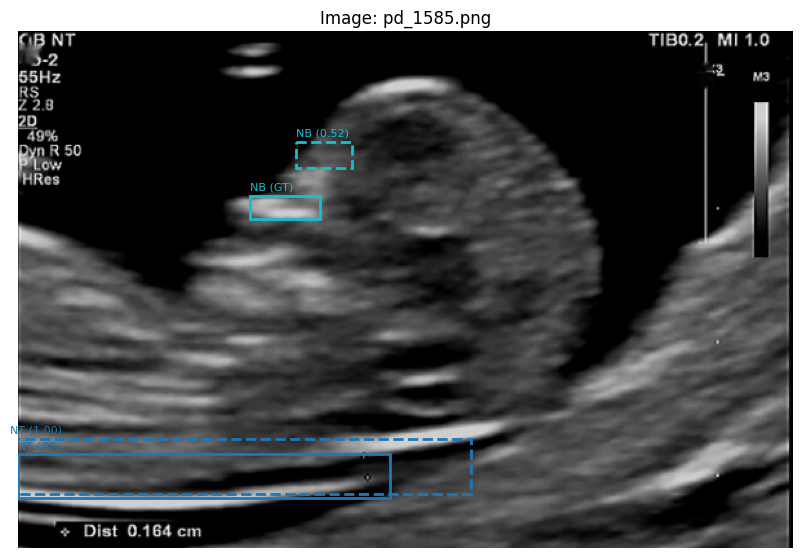

In [123]:
idx = np.random.choice(len(TEST_DATASET))
visualize_prediction(best_model, TEST_DATASET, idx)

In [90]:
test_dl = DataLoader(TEST_DATASET, BATCH_SIZE, False, num_workers=0, pin_memory=True)
mean_test_loss, mean_test_ap = validate(best_model, test_dl)
print(f"Mean Test Loss: {mean_test_loss:.2f}")
print(f"Mean Test aAP@0.5: {mean_test_ap:.2f}")

Mean Test Loss: 0.66
Mean Test aAP@0.5: 0.05


## Model Registration

In [91]:
# if best_run is not None:
#     artifact_name = best_model_checkpoint_path.replace(".pth", ".onnx").split(os.sep)[-1]
#     model_version = mlflow.register_model(
#         model_uri=f"{MLFLOW_EXPERIMENT.artifact_location}/{best_run.info.run_id}/artifacts/{artifact_name}",
#         name=MODEL_NAME
#     )